In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from s2cloudless import S2PixelCloudDetector, CloudMaskRequest
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
import scipy
from scipy.sparse.linalg import splu
from skimage.transform import resize
from sentinelhub import CustomUrlParam
from time import time as timer
from time import sleep as sleep
import multiprocessing

/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%run ../src/slope.py
%run ../src/utils-bilinear.py
%run ../src/dsen2/utils/DSen2Net.py
#!source ~/.bash_profile

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
dates = ('2018-12-15', '2020-01-15')
SIZE = 9*5
IMSIZE = (SIZE * 14)+2

cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2)

# Helper functions (to be moved to a utils file)

In [4]:
EPSG = CRS.WGS84
GRID_SIZE_X = 1
GRID_SIZE_Y = 1

IMAGE_X = 14*GRID_SIZE_X
IMAGE_Y = 14*GRID_SIZE_Y

TEST_X = 5
TEST_Y = 5

with open("../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']

In [5]:
# These arrays are for smoothly overlapping the cloud and shadow interpolation
c_arr = np.array([[1, 1, 1, 1, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 2, 3, 2, 1,],
                  [1, 2, 2, 2, 1,],
                  [1, 1, 1, 1, 1,],])
                  
c_arr = c_arr / 3
o_arr = 1 - c_arr
c_arr = np.tile(c_arr[:, :, np.newaxis], (1, 1, 10))
o_arr = np.tile(o_arr[:, :, np.newaxis], (1, 1, 10))

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

In [6]:
def calculate_epsg(coord):
    ''' Returns a UTM EPSG for a lat, long coord'''
    ___xx = 10 + ((coord[0] - (-126)) // 6)
    __x__ = 6 if coord[1] > 0 else 7
    return int( str(32) + str(__x__) + str(___xx)[:-2] )
    
def offset_x(coord, offset):
    ''' Converts a WGS 84 to UTM, adds meters, and converts back'''
    epsg = calculate_epsg(coord)
    coord = convertCoords(coord, 4326, epsg)
    coord[0] += offset
    coord = convertCoords(coord, epsg, 4326)
    return coord
    
def offset_y(coord, offset):
    ''' Converts a WGS 84 to UTM, adds meters, and converts back'''
    epsg = calculate_epsg(coord)
    coord = convertCoords(coord, 4326, epsg)
    coord[1] += offset
    coord = convertCoords(coord, epsg, 4326)
    return coord

def calculate_bbx(coord, step_x, step_y, expansion):
    ''' Calculates the four corners of a bounding box of step_x * step_y offset from coord'''
    coord_bl = np.copy(coord)
    coord1 = offset_x(coord_bl, 6300*step_x - expansion)
    coord1 = offset_y(coord1 , 6300*step_y - expansion)
    
    coord_tr = np.copy(coord)
    coord2 = offset_x(coord_tr, 6300*(step_x + 1) + expansion)
    coord2 = offset_y(coord2, 6300*(step_y + 1) + expansion)
    bbx = (coord2, coord1)
    return bbx

In [7]:
dates

('2018-12-15', '2020-01-15')

# Data download

In [10]:
def try_function(func, n_tries = 5, *args, **kwargs):
    for try_ in range(0, n_tries):
        try:
            returns = func(*args, **kwargs)
        except Exception:
            print("Trying again in 20 seconds")
            time.sleep(20)
        else:
            continue

In [ ]:
def identify_clouds(bbox, epsg = EPSG, dates = dates):
    '''
    - Download the CLOUD_DETECTION layer from sentinel-hub
    - Process cloud probabiiliity
    - Return cloud probability map
    '''
    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            cloud_request = WmsRequest(
                layer='CLOUD_DETECTION',
                bbox=box,
                time=dates,
                width=(5*9*14)+2,
                height=(5*9*14)+2,
                image_format = MimeType.TIFF_d32f,
                maxcc=0.7,
                instance_id=API_KEY,
                custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                time_difference=datetime.timedelta(hours=48),
            )

            cloud_img = cloud_request.get_data()
            cloud_probs = cloud_detector.get_cloud_probability_maps(np.array(cloud_img))
            print("Cloud probs: {}".format(cloud_probs.shape))
            return cloud_probs
        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep(30)
    
    
def download_dem(bbox, epsg = EPSG):
    #@valid
    for try_ in range(0, 5):
        try:
            box = BBox(bbox, crs = epsg)
            dem_s = (630)+4
            dem_request = WmsRequest(data_source=DataSource.DEM,
                                 layer='DEM',
                                 bbox=box,
                                 width=dem_s,
                                 height=dem_s,
                                 instance_id=API_KEY,
                                 image_format=MimeType.TIFF_d32f,
                                 custom_url_params={CustomUrlParam.SHOWLOGO: False})
            dem_image = dem_request.get_data()[0]
            dem_image = calcSlope(dem_image.reshape((1, dem_s, dem_s)),
                          np.full((dem_s, dem_s), 10), np.full((dem_s, dem_s), 10), zScale = 1, minSlope = 0.02)
            dem_image = dem_image.reshape((dem_s,dem_s, 1))
            dem_image = dem_image[1:dem_s-1, 1:dem_s-1, :]
            return dem_image #/ np.max(dem_image)
        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)
            pass

def download_layer(bbox, epsg = EPSG, dates = dates, year = 2019):
    for try_ in range(5):
        try:
            box = BBox(bbox, crs = epsg)
            image_request = WcsRequest(
                    layer='L2A20',
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=0.7,
                    resx='10m', resy='10m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                        constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                    time_difference=datetime.timedelta(hours=48),
                )
            img_bands = image_request.get_data()
            img_20 = np.stack(img_bands)
            print("Original size: {}".format(img_20.shape))
            img_20 = resize(img_20, (img_20.shape[0], 632, 632, img_20.shape[-1]), order = 0)

            image_request = WcsRequest(
                    layer='L2A10',
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=0.7,
                    resx='10m', resy='10m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'BICUBIC',
                                        constants.CustomUrlParam.UPSAMPLING: 'BICUBIC'},
                    time_difference=datetime.timedelta(hours=48),
            )

            img_bands = image_request.get_data()
            img_10 = np.stack(img_bands)
            print("Original 10 size: {}".format(img_10.shape))
            img_10 = resize(img_10, (img_10.shape[0], 632, 632, img_10.shape[-1]), order = 0)
            #shadows = img_10[:, :, :, -1]
            #img_10 = img_10[:, :, :, :-1]

            #shadows[np.where(shadows != 3)] = 0
            #shadows[np.where(shadows == 3)] = 1
            #print("Data shape: {}".format(shadows.shape))
            #shadow_sum = np.sum(shadows, axis = (1, 2))
            #shadow_steps = np.argwhere(shadow_sum > (IMSIZE*IMSIZE) / 4)

            img = np.concatenate([img_10, img_20], axis = -1)

            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)

            return img, image_dates#, shadows, shadow_steps

        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)
        
        
        
def download_sentinel_1(bbox, epsg = EPSG, dates = dates, layer = "SENT", year = 2019):
    for try_ in range(5):
        try:
            box = BBox(bbox, crs = epsg)
            image_request = WcsRequest(
                    layer=layer,
                    bbox=box,
                    time=dates,
                    image_format = MimeType.TIFF_d32f,
                    maxcc=1.0,
                    resx='5m', resy='5m',
                    instance_id=API_KEY,
                    custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                                        constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
                    time_difference=datetime.timedelta(hours=48),
                )
            img_bands = image_request.get_data()
            s1 = np.stack(img_bands)
            s1 = resize(s1, (s1.shape[0], 632*2, 632*2, s1.shape[-1]), order = 0)
            s1 = np.reshape(s1, (s1.shape[0], s1.shape[1]//2, 2, s1.shape[2] // 2, 2, s1.shape[-1]))
            s1 = np.mean(s1, (2, 4))
            #s1 = s1[:, 8:24, 8:24, :]

            image_dates = []
            for date in image_request.get_dates():
                if date.year == year - 1:
                    image_dates.append(-365 + starting_days[(date.month-1)] + date.day)
                if date.year == year:
                    image_dates.append(starting_days[(date.month-1)] + date.day)
                if date.year == year + 1:
                    image_dates.append(365 + starting_days[(date.month-1)]+date.day)
            image_dates = np.array(image_dates)
            to_remove = np.argwhere(np.max(s1, (1, 2, 3)) == 1.).flatten()
            s1 = np.delete(s1, to_remove, 0)
            #print(np.max(s1, (1, 2, 3)))
            image_dates = np.delete(image_dates, to_remove)
            return s1, image_dates

        except Exception as e:
            #logging.fatal(e, exc_info=True)
            sleep((try_+1)*30)

# Cloud and shadow removal

In [ ]:
def remove_cloud_and_shadows(tiles, c_probs, shadows, image_dates):
    '''
    - Iterate through a window size over each time step
    - Identify whether or not there are clouds and shadows there
    - If there are, interpolate the 5*5 window with clean imagery for all bands
    '''
    wsize = 5
    c_probs = c_probs - np.min(c_probs, axis = 0)
    c_probs[np.where(c_probs > 0.33)] = 1.
    c_probs[np.where(c_probs < 0.33)] = 0.
    c_probs = np.reshape(c_probs, (c_probs.shape[0], 632//8, 8, 632//8, 8))
    c_probs = np.sum(c_probs, (2, 4))
    c_probs = resize(c_probs, (c_probs.shape[0], 632, 632), 0)
    c_probs[np.where(c_probs < 16)] = 0
    c_probs[np.where(c_probs >= 16)] = 1
    secondary_c_probs = np.copy(c_probs)
    c_probs += shadows
    c_probs[np.where(c_probs >= 1.)] = 1.
    number_interpolated = 0
    for cval in tnrange(0, IMSIZE - 4, 2):
        for rval in range(0, IMSIZE - 4, 2):
            subs = c_probs[:, cval:cval + wsize, rval:rval+wsize]
            sums = np.sum(subs, axis = (1, 2))
            satisfactory = [x for x in range(c_probs.shape[0]) if sums[x] < 8]
            satisfactory = np.array(satisfactory)
            for date in range(0, tiles.shape[0]):
                if np.sum(subs[date, :, :]) > 8:
                    number_interpolated += 1
                    before, after = calculate_proximal_steps(date, satisfactory)
                    before = date + before
                    after = date + after
                    bef = tiles[before, cval:cval+wsize, rval:rval+wsize, : ]
                    aft = tiles[after, cval:cval+wsize, rval:rval+wsize, : ]
                    before = image_dates[before]
                    after = image_dates[after]
                    before_diff = abs(image_dates[date] - before)
                    after_diff = abs(image_dates[date] - after)
                    bef_wt = 1 - before_diff / (before_diff + after_diff)
                    aft_wt = 1 - bef_wt
                    candidate = bef_wt*bef + aft_wt*aft
                    candidate = candidate*c_arr + tiles[date, cval:cval+wsize, rval:rval+wsize, : ]*o_arr
                    tiles[date, cval:cval+wsize, rval:rval+wsize, : ] = candidate 
    print("A total of {} pixels were interpolated".format(number_interpolated))
    return tiles, c_probs, secondary_c_probs

def remove_missed_clouds(img):
    iqr = np.percentile(img[:, :, :, 3].flatten(), 75) - np.percentile(img[:, :, :, 3].flatten(), 25)
    thresh_t = np.percentile(img[:, :, :, 3].flatten(), 75) + iqr*2
    thresh_b = np.percentile(img[:, :, :, 3].flatten(), 25) - iqr*2
    diffs_fw = np.diff(img, 1, axis = 0)
    diffs_fw = np.mean(diffs_fw, axis = (1, 2, 3))
    diffs_fw = np.array([0] + list(diffs_fw))
    diffs_bw = np.diff(np.flip(img, 0), 1, axis = 0)
    diffs_bw = np.flip(np.mean(diffs_bw, axis = (1, 2, 3)))
    diffs_bw = np.array(list(diffs_bw) + [0])
    diffs = abs(diffs_fw - diffs_bw) * 100 # 3, -3 -> 6, -3, 3 -> 6, -3, -3
    #diffs = [int(x) for x in diffs]
    outlier_percs = []
    for step in range(img.shape[0]):
        bottom = len(np.argwhere(img[step, :, :, 3].flatten() > thresh_t))
        top = len(np.argwhere(img[step, :, :, 3].flatten() < thresh_b))
        p = 100* ((bottom + top) / (IMSIZE*IMSIZE))
        outlier_percs.append(p)
    to_remove = np.argwhere(np.array(outlier_percs) > 20)
    return to_remove

# Data interpolation

In [ ]:
diagonals = np.zeros(2*2+1)
diagonals[2] = 1.
for i in range(2):
    diff = diagonals[:-1] - diagonals[1:]
    diagonals = diff
offsets = np.arange(2+1)
shape = (70, 72)

def smooth(y, lmbd = 800, diagonals = diagonals, offsets = offsets, shape = shape, d = 2):
    ''' 
    Apply whittaker smoothing to a 1-dimensional array, returning a 1-dimensional array
    '''
    E = sparse.eye(72, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z

def calculate_and_save_best_images(img_bands, image_dates):
    '''
    
    '''

    biweekly_dates = [day for day in range(0, 360, 5)] # ideal imagery dates are every 15 days
    
    # Identify the dates where there is < 20% cloud cover
    #satisfactory_ids = list(np.argwhere(np.array(means) < 4.).reshape(-1, )) 
    satisfactory_ids = [x for x in range(0, img_bands.shape[0])]
    satisfactory_dates = [value for idx, value in enumerate(image_dates) if idx in satisfactory_ids]
    
    
    selected_images = {}
    for i in biweekly_dates:
        distances = [abs(date - i) for date in satisfactory_dates]
        closest = np.min(distances)
        closest_id = np.argmin(distances)
        # If there is imagery within 8 days, select it
        if closest < 8:
            date = satisfactory_dates[closest_id]
            image_idx = int(np.argwhere(np.array(image_dates) == date)[0])
            selected_images[i] = {'image_date': [date], 'image_ratio': [1], 'image_idx': [image_idx]}
        # If there is not imagery within 8 days, look for the closest above and below imagery
        else:
            distances = np.array([(date - i) for date in satisfactory_dates])
            # Number of days above and below the selected date of the nearest clean imagery
            above = distances[np.where(distances < 0, distances, -np.inf).argmax()]
            below = distances[np.where(distances > 0, distances, np.inf).argmin()]
            if abs(above) > 240: # If date is the last date, occassionally argmax would set above to - number
                above = below
            if abs(below) > 240:
                below = above
            if above != below:
                below_ratio = above / (above - below)
                above_ratio = 1 - below_ratio
            else:
                above_ratio = below_ratio = 0.5
                
            # Extract the image date and imagery index for the above and below values
            above_date = i + above
            above_image_idx = int(np.argwhere(np.array(image_dates) == above_date)[0])
            
            below_date = i + below
            below_image_idx = int(np.argwhere(np.array(image_dates) == below_date)[0])
            
            selected_images[i] = {'image_date': [above_date, below_date], 'image_ratio': [above_ratio, below_ratio],
                                 'image_idx': [above_image_idx, below_image_idx]}
                            
    max_distance = 0
    
    for i in selected_images.keys():
        #print(i, selected_images[i])
        if len(selected_images[i]['image_date']) == 2:
            dist = selected_images[i]['image_date'][1] - selected_images[i]['image_date'][0]
            if dist > max_distance:
                max_distance = dist
    
    print("Maximum time distance: {}".format(max_distance))
        
    keep_steps = []
    for i in selected_images.keys():
        info = selected_images[i]
        if len(info['image_idx']) == 1:
            step = img_bands[info['image_idx'][0]]
        if len(info['image_idx']) == 2:
            step1 = img_bands[info['image_idx'][0]] * 0.5#info['image_ratio'][0]
            step2 = img_bands[info['image_idx'][1]] * 0.5 #info['image_ratio'][1]
            step = step1 + step2
        keep_steps.append(step)
        
    keep_steps = np.stack(keep_steps)
    return keep_steps



# Tiling and coordinate selection functions

In [ ]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda - useable
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.316919, 2.581680) # niger
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # weest mamprusi, ghana
#coords = (7.702058, -0.709011) # brong ahafo, bono east
#coords = (10.097017, -2.439068)# close to wa, has been done
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (7.398111, -1.269223) # cocoa
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (-20.147320, -40.837770) BR 2
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
#coords = (4.179529, -74.889171) # colombia
#coords = (6.518909, -0.826008) # kwahu large
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.757749, -90.004949) # elsalvador imposible
#coords = (13.727334, -90.015579) # elsalvador imposible2
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (-36.431237, -71.872030) # Chile
#coords = (12.398014, -86.963042) # Nicaragua
#coords = (13.933745, -84.690842) # Bonanza, Nicaragua
coords = (14.096664, -88.720304) # Honduras
coords = (coords[1], coords[0])
OUTPUT_FOLDER = '../tile_data/honduras_large/'
#13.567962754335872

#borders = bounding_box(coords, 10*(SIZE*14), 10*(SIZE*14), expansion = 0)
#print(borders)

In [ ]:
MDL_PATH = "../src/dsen2/models/"

input_shape = ((4, None, None), (6, None, None))
model = s2model(input_shape, num_layers=6, feature_size=128)
predict_file = MDL_PATH+'s2_032_lr_1e-04.hdf5'
print('Symbolic Model Created.')

model.load_weights(predict_file)

def DSen2(d10, d20):
    test = [d10, d20]
    input_shape = ((4, None, None), (6, None, None))
    prediction = _predict(test, input_shape, deep=False)
    #prediction *= 5
    return prediction

def _predict(test, input_shape, model = model, deep=False, run_60=False):
    
    print("Predicting using file: {}".format(predict_file))
    prediction = model.predict(test, verbose=1)
    return prediction

In [ ]:
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)

In [ ]:
def calculate_proximal_steps(date, satisfactory):
    arg_before = None
    arg_after = None
    if date > 0:
        idx_before = satisfactory - date
        arg_before = idx_before[np.where(idx_before < 0, idx_before, -np.inf).argmax()]
    if date < np.max(satisfactory):
        idx_after = satisfactory - date
        arg_after = idx_after[np.where(idx_after > 0, idx_after, np.inf).argmin()]
    if not arg_after and not arg_before:
        arg_after = date
        arg_before = date
    if not arg_after:
        arg_after = arg_before
    if not arg_before:
        arg_before = arg_after
    #print(arg_before, date, arg_after)
    return arg_before, arg_after

In [ ]:
def rank_array(arr):
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

In [ ]:
def mcm_shadow_mask(arr, c_probs):
    #' From "Cloud and cloud shadow masking for Sentinel-2 using multi-
    #         temporal images in global area. Candra et al. 2020."
    #'[B02,B03,B04, B08, B05,B06,B07, B8A,B11,B12]
    #'[ 0 , 1 , 2 , 3  , 4  , 5,  6   7  , 8  , 9]'
    mean_c_probs = np.mean(c_probs, axis = (1, 2))
    cloudy_steps = np.argwhere(mean_c_probs > 0.25)
    images_clean = np.delete(arr, cloudy_steps, 0)
    cloud_ranks = rank_array(mean_c_probs)
    diffs = abs(np.sum(arr - np.mean(images_clean, axis = 0), axis = (1, 2, 3)))
    diff_ranks = rank_array(diffs)
    overall_rank = diff_ranks + cloud_ranks
    reference_idx = np.argmin(overall_rank)
    ri = arr[reference_idx]
    print(reference_idx)
    
    nir_means = np.mean(arr[:, :, :, 3], axis = (0))
    
    shadows = np.zeros((arr.shape[0], 632, 632))    
    # Candra et al. 2020
    
    for time in tnrange(arr.shape[0]):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[2]):
                ti_slice = arr[time, x, y]
                ri_slice = ri[x, y]
                deltab2 = ti_slice[0] - ri_slice[0]
                deltab3 = ti_slice[1] - ri_slice[1]
                deltab4 = ti_slice[2] - ri_slice[2]
                deltab8a = ti_slice[7] - ri_slice[7]
                deltab11 = ti_slice[8] - ri_slice[8]

                if deltab2 < 0.1:
                    if deltab3 < 0.08:
                        if deltab4 < 0.08:
                            if deltab8a < -0.04:
                                if deltab11 < -0.04:
                                    if ti_slice[0] < 0.0950:
                                        shadows[time, x, y] = 1.
                                        
    # Additional 3 time-window NIR thresholding
    
    for time in tnrange(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    time_adjusted = np.max([time, 1])
                    time_adjusted = np.min([time_adjusted, shadows.shape[0] - 2])
                    # check before and after
                    if shadows[time_adjusted + 1, x, y] == 1 or shadows[time_adjusted-1, x, y] == 1:
                        nir_mean = nir_means[x, y]
                        nir_before = arr[time_adjusted - 1, x, y, 3] - nir_mean
                        nir_now = arr[time, x, y, 3] - nir_mean
                        nir_next = arr[time_adjusted + 1, x, y, 3] - nir_mean
                        if nir_now > nir_mean * 0.75:
                            shadows[time, x, y] = 0
                        if nir_next or nir_before <= nir_now:
                            shadows[time, x, y] = 0
                         
                            
    # Remove shadows if cannot coreference a cloud
    shadow_large = np.reshape(shadows, (shadows.shape[0], 79, 8, 79, 8))
    shadow_large = np.sum(shadow_large, axis = (2, 4))
    
    cloud_large = np.copy(c_probs)
    cloud_large[np.where(c_probs > 0.33)] = 1.
    cloud_large[np.where(c_probs < 0.33)] = 0.
    cloud_large = np.reshape(cloud_large, (shadows.shape[0], 79, 8, 79, 8))
    cloud_large = np.sum(cloud_large, axis = (2, 4))
    for time in tnrange(shadow_large.shape[0]):
        for x in range(shadow_large.shape[1]):
            x_low = np.max([x - 8, 0])
            x_high = np.min([x + 8, shadow_large.shape[1] - 1])
            for y in range(shadow_large.shape[2]):
                y_low = np.max([y - 8, 0])
                y_high = np.min([y + 8, shadow_large.shape[1] - 1])
                if shadow_large[time, x, y] < 8:
                    shadow_large[time, x, y] = 0.
                if shadow_large[time, x, y] >= 8:
                    shadow_large[time, x, y] = 1.
                c_prob_window = cloud_large[time, x_low:x_high, y_low:y_high]
                if np.max(c_prob_window) < 16:
                    shadow_large[time, x, y] = 0.
                    
    shadow_large = resize(shadow_large, (shadow_large.shape[0], 632, 632), order = 0)
    shadows *= shadow_large
    
    # Go through and aggregate the shadow map to an 80m grid, and extend it one grid size around
    # any positive ID
    
    shadows = np.reshape(shadows, (shadows.shape[0], 79, 8, 79, 8))
    shadows = np.sum(shadows, axis = (2, 4))
    shadows[np.where(shadows < 8)] = 0.
    shadows[np.where(shadows >= 8)] = 1.
    
    shadows_new = np.zeros_like(shadows)
    for time in range(shadows.shape[0]):
        for x in range(shadows.shape[1]):
            for y in range(shadows.shape[2]):
                if shadows[time, x, y] == 1:
                    min_x = np.max([x - 1, 0])
                    max_x = np.min([x + 2, 78])
                    min_y = np.max([y - 1, 0])
                    max_y = np.min([y + 2, 78])
                    for x_idx in range(min_x, max_x):
                        for y_idx in range(min_y, max_y):
                            shadows_new[time, x_idx, y_idx] = 1.
    shadows_new = resize(shadows_new, (shadows.shape[0], 632, 632), order = 0)
    return shadows_new
    
#c_probs = np.load(OUTPUT_FOLDER + "raw/clouds/clouds_0_0.npy")
#arr = x
#mask2 = mcm_shadow_mask(x, c_probs)

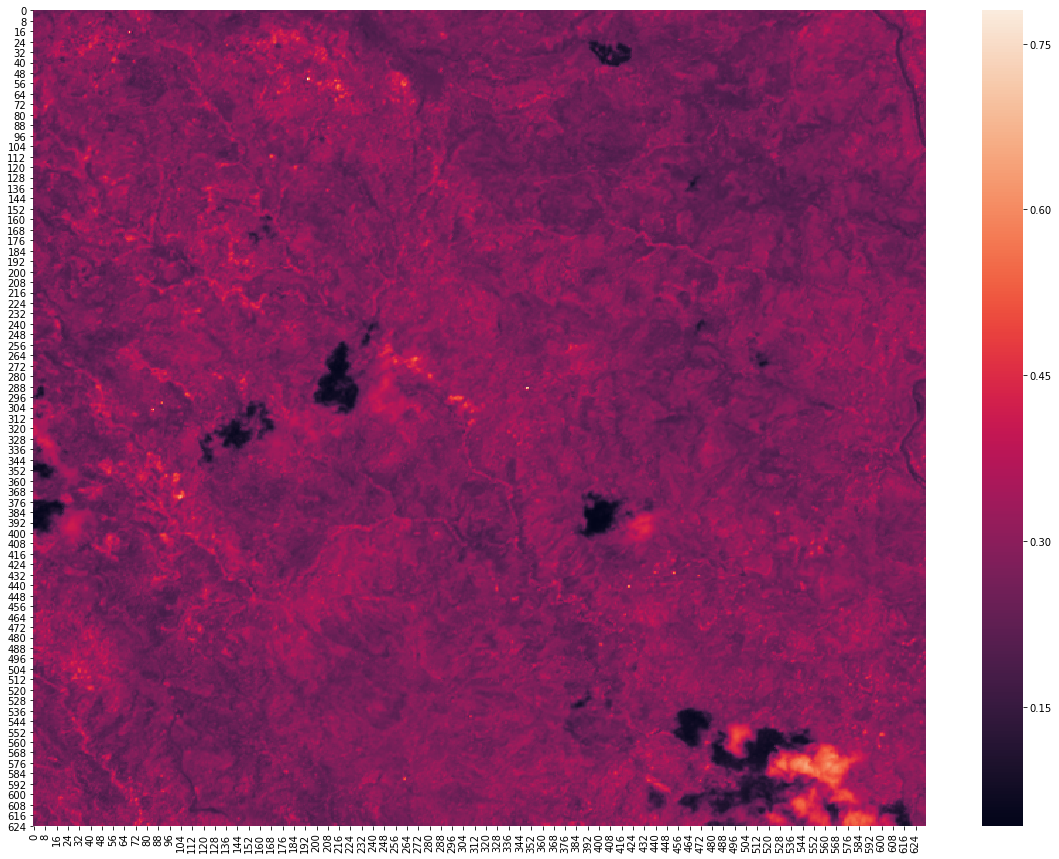

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 15))


x = np.load(OUTPUT_FOLDER + "raw/s2/0_0.npy")
sns.heatmap(x[23, :, :, 3])

In [ ]:
def find_and_make_dirs(dirs):
    if not os.path.exists(os.path.realpath(dirs)):
        os.makedirs(os.path.realpath(dirs))

def make_output_and_temp_folders(idx, output_folder = OUTPUT_FOLDER):
    find_and_make_dirs(output_folder + "raw/")
    find_and_make_dirs(output_folder + "raw/clouds/")
    find_and_make_dirs(output_folder + "raw/s1/")
    find_and_make_dirs(output_folder + "raw/s2/")
    find_and_make_dirs(output_folder + "raw/misc/")
    find_and_make_dirs(output_folder + "processed/")

def download_large_tile(coord, step_x, step_y, folder = OUTPUT_FOLDER, year = 2019):
    '''
    Ideally the folder structure should be as follows:
     - Raw
         - Cloud
              - Y*5, X*5
         - Sentinel 1
         - Sentinel 2
         - DEM
         - Dates
     - Processed
         - Y, X
         
    Methodological questions to address:
        - Should we download all images for a region first, and then process?     - Seems unnecessary
          This would allow for matching up the borders
        - Remove dirty steps for the whole tile or by subtiles 
        - Is this the proper time to address the interpolation of clouds (?)
        - Make sure that cloud shadows line up with clouds                        - X
        - Make sure that sentinel 1 is properly matched up and items are removed  - X
         
    The strategy is as follows:
        - Download 5*9 by 5*9 cloud, S1, S2, DEM, dates, save to folders          - X
        - Load each start:start+128 tile                                          - X
        - Remove dirty steps, missing images, missed clouds, ratios               - X
        - Superresolve                                                            - X
        - Indices                                                                 - X
        - Calculate_and_save_best_images                                          - X
        - Whittaker smooth                                                        - X
        - Fuse S1
        - Save to processed / y / x
        - Iterate for each of the large sub-tiles
    
    '''
    print(coord)
    bbx = calculate_bbx(coord, step_x, step_y, expansion = 10)
    print(bbx)
    dem_bbx = calculate_bbx(coord, step_x, step_y, expansion = 20)
    idx = str(step_y) + "_" + str(step_x)
    print(idx)
    if not os.path.exists(folder + "raw/clouds/clouds_{}.npy".format(idx)):
        idx = str(idx)

        print("Making raw folders")
        make_output_and_temp_folders(idx)

        print("Calculating cloud cover")
        cloud_probs = identify_clouds(bbx) # integrate cloud shadow here
        np.save(folder + "raw/clouds/clouds_{}.npy".format(idx), cloud_probs)

        print("Downloading S1")
        s1, s1_dates = download_sentinel_1(bbx, layer = "SENT")
        s1 = process_sentinel_1_tile(s1, s1_dates)
        np.save(folder + "raw/s1/{}.npy".format(idx), s1)
        np.save(folder + "raw/misc/s1_dates_{}".format(idx), np.array(s1_dates))

        print("Downloading S2")
        s2, s2_dates = download_layer(bbx)
        np.save(folder + "raw/s2/{}.npy".format(idx), s2)
        np.save(folder + "raw/misc/s2_dates_{}".format(idx), np.array(s2_dates))
        #np.save(folder + "raw/clouds/shadows_{}".format(idx), np.array(shadows))

        print("Downloading DEM")
        dem = download_dem(dem_bbx) # get the DEM BBOX
        np.save(folder + "raw/misc/dem_{}.npy".format(idx), dem)
    

In [ ]:
def calculate_bad_steps(sentinel2, clouds):
    n_cloud_px = np.array([len(np.argwhere(clouds[x, :, :].reshape((632)*(632)) > 0.3)) for x in range(clouds.shape[0])])
    cloud_steps = np.argwhere(n_cloud_px > 632**2 / 5)
    missing_images = [np.argwhere(sentinel2[x, :, : :].flatten() == 0.0) for x in range(sentinel2.shape[0])]
    missing_images = np.array([len(x) for x in missing_images])
    missing_images_p = [np.argwhere(sentinel2[x, :, : :10].flatten() >= 1) for x in range(sentinel2.shape[0])]
    missing_images_p = np.array([len(x) for x in missing_images_p])
    missing_images += missing_images_p
    missing_images = np.argwhere(missing_images >= 100)
    print(cloud_steps)
    print(missing_images)
    #perc_shadow_px = np.sum(shadows, axis = (1, 2) / (79**2))
    #shadow_steps = np.argwhere(perc_shadow_px > 20)
    to_remove = np.unique(np.concatenate([cloud_steps.flatten(), missing_images.flatten()]))#, shadow_steps]))
    return to_remove

def superresolve(sentinel2):
    d10 = sentinel2[:, :, :, 0:4]
    d20 = sentinel2[:, :, :, 4:10]

    d10 = np.swapaxes(d10, 1, -1)
    d10 = np.swapaxes(d10, 2, 3)
    d20 = np.swapaxes(d20, 1, -1)
    d20 = np.swapaxes(d20, 2, 3)
    superresolved = DSen2(d10, d20)
    superresolved = np.swapaxes(superresolved, 1, -1)
    superresolved = np.swapaxes(superresolved, 1, 2)

    # returns band IDXs 3, 4, 5, 7, 8, 9
    return superresolved

def process_sentinel_1_tile(sentinel1, dates):
    s1 = calculate_and_save_best_images(sentinel1, dates)
    # Retain only iamgery every 15 days
    biweekly_dates = np.array([day for day in range(0, 360, 5)])
    to_remove = np.argwhere(biweekly_dates % 15 != 0)
    s1 = np.delete(s1, to_remove, 0)
    return s1


def interpolate_array(x):
    no_dem = np.delete(x, 10, -1)
    no_dem = np.reshape(no_dem, (72, 128*128*14))
    no_dem = np.swapaxes(no_dem, 0, 1)

    pool = multiprocessing.Pool(6)
    no_dem = pool.map(smooth, no_dem)
    pool.close()
    pool.join()

    no_dem = np.swapaxes(no_dem, 0, 1)
    no_dem = np.reshape(no_dem, (72, 128, 128, 14))
    x[:, :, :, :10] = no_dem[:, :, :, :10]
    x[:, :, :, 11:] = no_dem[:, :, :, 10:]

    biweekly_dates = np.array([day for day in range(0, 360, 5)])
    to_remove = np.argwhere(biweekly_dates % 15 != 0)
    x = np.delete(x, to_remove, 0)
    return x

def process_large_tile(step_x, step_y, folder = OUTPUT_FOLDER):
    idx = str(step_y) + "_" + str(step_x)
    x_vals = []
    y_vals = []
    # save to disk
    for i in range(25):
        y_val = (24 - i) // 5
        x_val = 5 - ((25 - i) % 5)
        x_val = 0 if x_val == 5 else x_val
        x_vals.append(x_val)
        y_vals.append(y_val)
        
    y_vals = [i + (5*step_y) for i in y_vals]
    x_vals = [i + (5*step_x) for i in x_vals]
    print(y_vals, x_vals)
    
    
    processed = True
    for x, y in zip(x_vals, y_vals):
        if not os.path.exists(folder + "processed/{}/{}.npy".format(str(y), str(x))):
            processed = False
    if not processed:
        
        clouds = np.load(folder + "raw/clouds/clouds_{}.npy".format(idx))
        sentinel1 = np.load(folder + "raw/s1/{}.npy".format(idx))
        radar_dates = np.load(folder + "raw/misc/s1_dates_{}.npy".format(idx))
        sentinel2 = np.load(folder + "raw/s2/{}.npy".format(idx))
        dem = np.load(folder + "raw/misc/dem_{}.npy".format(idx))
        print(dem.shape)
        image_dates = np.load(folder + "raw/misc/s2_dates_{}.npy".format(idx))
        print("The files have been loaded")

        #sentinel1 = process_sentinel_1_tile(sentinel1, radar_dates)
        to_remove = calculate_bad_steps(sentinel2, clouds)
        sentinel2 = np.delete(sentinel2, to_remove, axis = 0)
        clouds = np.delete(clouds, to_remove, axis = 0)
        image_dates = np.delete(image_dates, to_remove)
        print("Cloudy and missing images removed, radar processed")

        to_remove = remove_missed_clouds(sentinel2)
        sentinel2 = np.delete(sentinel2, to_remove, axis = 0)
        clouds = np.delete(clouds, to_remove, axis = 0)
        image_dates = np.delete(image_dates, to_remove)
        print("Missed cloudy images removed")

        new_shadows = mcm_shadow_mask(sentinel2, clouds)
        print(new_shadows.shape)
        x, _, _ = remove_cloud_and_shadows(sentinel2, clouds, new_shadows, image_dates)
        print("Clouds and shadows interpolated")


        index = 0
        for start_x, end_x in zip(range(0, 633, 126), range(128, 633, 126)):
            for start_y, end_y in zip(range(0, 633, 126), range(128, 633, 126)):
                print(index)
                if not os.path.exists(folder + "processed/{}/{}.npy".format(str(y_vals[index]), str(x_vals[index]))):
                    subtile = x[:, start_x:end_x, start_y:end_y, :]
                    resolved = superresolve(subtile)
                    subtile[:, :, :, 4:10] = resolved
                    dem_i = np.tile(dem[np.newaxis, start_x:end_x, start_y:end_y, :], (x.shape[0], 1, 1, 1))
                    subtile = np.concatenate([subtile, dem_i / 90], axis = -1)
                    subtile, amin = evi(subtile, verbose = True)
                    subtile = bi(subtile, verbose = True)
                    subtile = msavi2(subtile, verbose = True)
                    subtile = si(subtile, verbose = True)

                    subtile = calculate_and_save_best_images(subtile, image_dates)
                    subtile = interpolate_array(subtile)
                    subtile = np.concatenate([subtile, sentinel1[:, start_x:end_x,
                                                                start_y:end_y, :]], axis = -1)


                    out_y_folder = folder + "processed/{}/".format(str(y_vals[index]))
                    if not os.path.exists(os.path.realpath(out_y_folder)):
                        os.makedirs(os.path.realpath(out_y_folder))
                    np.save(folder + "processed/{}/{}.npy".format(str(y_vals[index]), str(x_vals[index])), subtile)
                index += 1
            
def clean_up_folders():
    pass

In [9]:
from tqdm import tnrange, tqdm_notebook

sleep(3600*8)
for x_tile in range(0, 5):
    for y_tile in range(0, 5):
        print(x_tile, y_tile)
        download_large_tile(coords, x_tile, y_tile)
        process_large_tile(x_tile, y_tile)
        time.sleep(20)
        #clean_up_folders(x_tile, y_tile)

0 0


NameError: name 'download_large_tile' is not defined